In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

#import iceplant_detection_functions as ipf
#import model_prep_and_evals as mpe


import warnings
import time

##  Initialize Dask

In [2]:
# for local Dask use
# import dask
# from dask.distributed import Client

# client = Client()  # Connect to distributed cluster and override default
# client

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/msai4earth-esa/iceplant_detection/dask_trials/dask-worker-space/worker-7exkloar', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37691,Workers: 4
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40477,Total threads: 1
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/34779/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:44837,


In [2]:
import dask
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
#cluster.adapt(minimum=4, maximum=50)
cluster.scale(30)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.a49fda6d31514983a702f7aa83fe12a4/status,


## Train model and predict on test

In [3]:
df = pd.read_csv(os.path.join('/home/jovyan/msai4earth-esa/iceplant_detection'
                              ,'feature_selection',
                              'samples_for_model.csv'))
df.drop(['Unnamed: 0','year','month','day_in_year','ndvi'], axis=1, inplace=True)
df.head(3)

,r,g,b,nir,iceplant
0,134,125,103,170,1
1,130,114,101,164,1
2,132,110,98,160,1


In [4]:
labels = np.array(df['iceplant'])
features = np.array(df.drop('iceplant', axis = 1))
X_train, X_test, y_train, y_test=  train_test_split(features, labels, 
                            test_size = 0.3, 
                            random_state = 42)

In [5]:
from dask_ml.wrappers import ParallelPostFit

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

ParallelPostFit(estimator=RandomForestClassifier(random_state=42))

In [7]:
predictions = rfc.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 1])

## Make dask data array of pixel values from NAIP scene raster 

In [6]:
import pystac_client 
import planetary_computer as pc

def get_item_from_id(itemid):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    search = catalog.search(
        collections=["naip"],
        ids = itemid)
    
    item = list(search.get_items())[0]
    # sign and open item
    return item

# ---------------------------------------------

def get_raster_from_item(item):
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)
    return ds

In [7]:
itemid = 'ca_m_3412037_nw_10_060_20200607'

item = get_item_from_id(itemid)
scene = get_raster_from_item(item).read([1,2,3,4])
scene.shape

(4, 12470, 10520)

In [10]:
pixels = scene.reshape([4,-1]).T
pixels.shape

(131184400, 4)

In [11]:
import dask.array as da

In [15]:
da_pixels = da.from_array(pixels, chunks=4372813)
da_pixels

dask.array<array, shape=(131184400, 4), dtype=uint8, chunksize=(4372813, 4), chunktype=numpy.ndarray>

In [16]:
scene_preds = rfc.predict(da_pixels)
scene_preds

dask.array<_predict, shape=(131184400,), dtype=int64, chunksize=(4372813,), chunktype=numpy.ndarray>

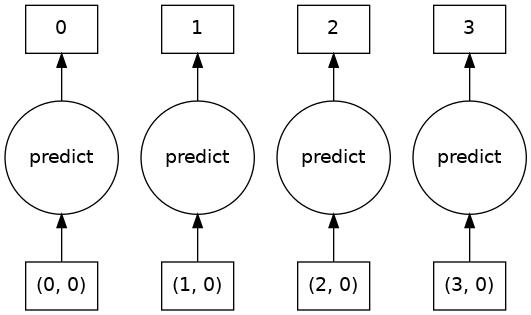

In [24]:
#scene_preds.visualize()

In [17]:
t0 = time.time()
#print('starting time: ', t0)

preds = scene_preds.compute()
print((time.time()-t0))

13.85432733297348


In [18]:
preds

array([0, 0, 0, ..., 0, 0, 0])

**Some notes about using dask for this setup**

Maybe avoid as much as possible introducing "pure" numpy operations into the dask workflow. Numpy runs really fast, even in large arrays like a complete NAIP scene and the overhead of parallelizing is greater than doing it directly. 

Check the dask graph before computing and always check if anything can be simplified. 

Automatic number of workers may not be ideal. The workers and chunks work hand-in-hand, so you may meed to tune both numbes simultaneously.



**Some good references:**

Best practices for size chunks and number of workers (summary: make each chunk about the size of an object which performs in the time you want, each chunk has to be at least 1MB in size, make # chunks a multiple of # workers)
https://www.dask.org/blog/configuring-a-distributed-dask-cluster

Connecting to the dask Gateway_Client in the Planetary Computer
https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/

Understainding the diagnostic panel (SUPER IMPORTANT)
https://docs.dask.org/en/latest/diagnostics-distributed.html

Parallel model prediction (using ParallelPostFit)
https://examples.dask.org/machine-learning/parallel-prediction.html